In [5]:
import sys
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

from src.models.evaluator import ModelEvaluator
from src.models.trainer import ModelTrainer
import joblib

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful!")
print(f"Project root: {project_root}")

✓ Imports successful!
Project root: C:\Users\aloag\personal-study\ctr-prediction-system


# Model Evaluation Notebook

This notebook demonstrates how to evaluate trained models:
- Load trained models
- Evaluate on test data
- Visualize performance metrics
- Analyze feature importance

## Prerequisites

Make sure you have:
1. ✅ Trained models (run `python scripts/train_models.py`)
2. ✅ Processed features (run `python scripts/create_features.py`)
3. ✅ Test data available


In [6]:
# Check if models exist and list available models
models_dir = project_root / "models"
print(f"Models directory: {models_dir}")

if not models_dir.exists():
    print("⚠️  Models directory does not exist!")
    print("\nPlease train models first:")
    print("  python scripts/train_models.py --input data/processed/features.csv --output-dir models/")
else:
    model_files = list(models_dir.glob("*_model.pkl"))
    if model_files:
        print(f"\n✓ Found {len(model_files)} trained model(s):")
        for model_file in model_files:
            print(f"  - {model_file.name}")
    else:
        print("\n⚠️  No trained models found!")
        print("Please train models first:")
        print("  python scripts/train_models.py --input data/processed/features.csv --output-dir models/")


Models directory: C:\Users\aloag\personal-study\ctr-prediction-system\models

✓ Found 3 trained model(s):
  - lightgbm_model.pkl
  - logistic_model.pkl
  - xgboost_model.pkl


## Load Models and Test Data


In [8]:
# Load test data
test_data_path = project_root / "data" / "processed" / "features_sample.csv"

if not test_data_path.exists():
    print(f"⚠️  Test data not found: {test_data_path}")
    print("\nPlease create features first:")
    print("  python scripts/create_features.py --input data/raw/impressions.csv --output data/processed/features.csv")
else:
    print(f"Loading test data from {test_data_path}...")
    
    if test_data_path.suffix == '.parquet':
        df = pd.read_parquet(test_data_path)
    else:
        df = pd.read_csv(test_data_path)
    
    print(f"✓ Loaded {len(df):,} rows, {len(df.columns)} columns")
    
    # Split into features and target
    feature_cols = [col for col in df.columns if col != 'clicked']
    X_test = df[feature_cols].select_dtypes(include=[np.number])
    y_test = df['clicked']
    
    print(f"✓ Test set prepared: {len(X_test):,} samples, {len(X_test.columns)} features")
    print(f"  CTR: {y_test.mean():.4f}")


Loading test data from C:\Users\aloag\personal-study\ctr-prediction-system\data\processed\features_sample.csv...
✓ Loaded 291,488 rows, 48 columns
✓ Test set prepared: 291,488 samples, 31 features
  CTR: 0.2046


## Load Trained Models


In [9]:
# Load models with error handling
models_dir = project_root / "models"
models = {}
scalers = {}
feature_names = None

# Try to load feature names
feature_names_path = models_dir / "feature_names.pkl"
if feature_names_path.exists():
    feature_names = joblib.load(feature_names_path)
    print(f"✓ Loaded feature names ({len(feature_names)} features)")
else:
    print("⚠️  Feature names not found, will use columns from test data")
    if 'X_test' in locals():
        feature_names = X_test.columns.tolist()

# Load available models
model_types = ['logistic', 'xgboost', 'lightgbm']

for model_type in model_types:
    model_path = models_dir / f"{model_type}_model.pkl"
    if model_path.exists():
        try:
            models[model_type] = joblib.load(model_path)
            print(f"✓ Loaded {model_type} model")
            
            # Load scaler if exists (for logistic regression)
            if model_type == 'logistic':
                scaler_path = models_dir / f"{model_type}_scaler.pkl"
                if scaler_path.exists():
                    scalers[model_type] = joblib.load(scaler_path)
                    print(f"  ✓ Loaded {model_type} scaler")
        except Exception as e:
            print(f"⚠️  Error loading {model_type} model: {e}")
    else:
        print(f"⚠️  {model_type} model not found: {model_path}")

if not models:
    print("\n❌ No models loaded!")
    print("Please train models first:")
    print("  python scripts/train_models.py --input data/processed/features.csv --output-dir models/")
else:
    print(f"\n✓ Successfully loaded {len(models)} model(s)")


✓ Loaded feature names (31 features)
✓ Loaded logistic model
  ✓ Loaded logistic scaler
✓ Loaded xgboost model
✓ Loaded lightgbm model

✓ Successfully loaded 3 model(s)


## Evaluate Models


In [10]:
# Evaluate all loaded models
if 'X_test' in locals() and 'y_test' in locals() and models:
    evaluator = ModelEvaluator()
    results = {}
    
    print("=" * 60)
    print("MODEL EVALUATION ON TEST SET")
    print("=" * 60)
    
    for model_name, model in models.items():
        print(f"\nEvaluating {model_name}...")
        
        # Prepare features (scale if needed)
        if model_name == 'logistic' and model_name in scalers:
            X_test_scaled = scalers[model_name].transform(X_test)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            # Ensure feature order matches
            if feature_names:
                X_test_ordered = X_test[[col for col in feature_names if col in X_test.columns]]
            else:
                X_test_ordered = X_test
            y_pred_proba = model.predict_proba(X_test_ordered)[:, 1]
        
        y_pred_binary = (y_pred_proba >= 0.5).astype(int)
        
        # Evaluate
        metrics = evaluator.evaluate(y_test, y_pred_proba, y_pred_binary)
        results[model_name] = {
            'metrics': metrics,
            'y_pred_proba': y_pred_proba,
            'y_pred_binary': y_pred_binary
        }
        
        print(f"  ROC-AUC: {metrics['roc_auc']:.4f}")
        print(f"  Log Loss: {metrics['log_loss']:.4f}")
        print(f"  PR-AUC: {metrics['pr_auc']:.4f}")
        if 'accuracy' in metrics:
            print(f"  Accuracy: {metrics['accuracy']:.4f}")
    
    # Compare models
    if len(results) > 1:
        print("\n" + "=" * 60)
        print("MODEL COMPARISON")
        print("=" * 60)
        comparison = pd.DataFrame({
            model: {
                'ROC-AUC': results[model]['metrics']['roc_auc'],
                'Log Loss': results[model]['metrics']['log_loss'],
                'PR-AUC': results[model]['metrics']['pr_auc']
            }
            for model in results.keys()
        }).T
        print(comparison.round(4))
else:
    print("⚠️  Cannot evaluate: Missing test data or models")
    print("Make sure you've:")
    print("  1. Created features: python scripts/create_features.py")
    print("  2. Trained models: python scripts/train_models.py")


MODEL EVALUATION ON TEST SET

Evaluating logistic...
  ROC-AUC: 0.9992
  Log Loss: 0.0273
  PR-AUC: 0.9964
  Accuracy: 0.9903

Evaluating xgboost...
  ROC-AUC: 0.9997
  Log Loss: 0.0217
  PR-AUC: 0.9990
  Accuracy: 0.9909

Evaluating lightgbm...
  ROC-AUC: 0.9997
  Log Loss: 0.0219
  PR-AUC: 0.9990
  Accuracy: 0.9908

MODEL COMPARISON
          ROC-AUC  Log Loss  PR-AUC
logistic   0.9992    0.0273  0.9964
xgboost    0.9997    0.0217  0.9990
lightgbm   0.9997    0.0219  0.9990


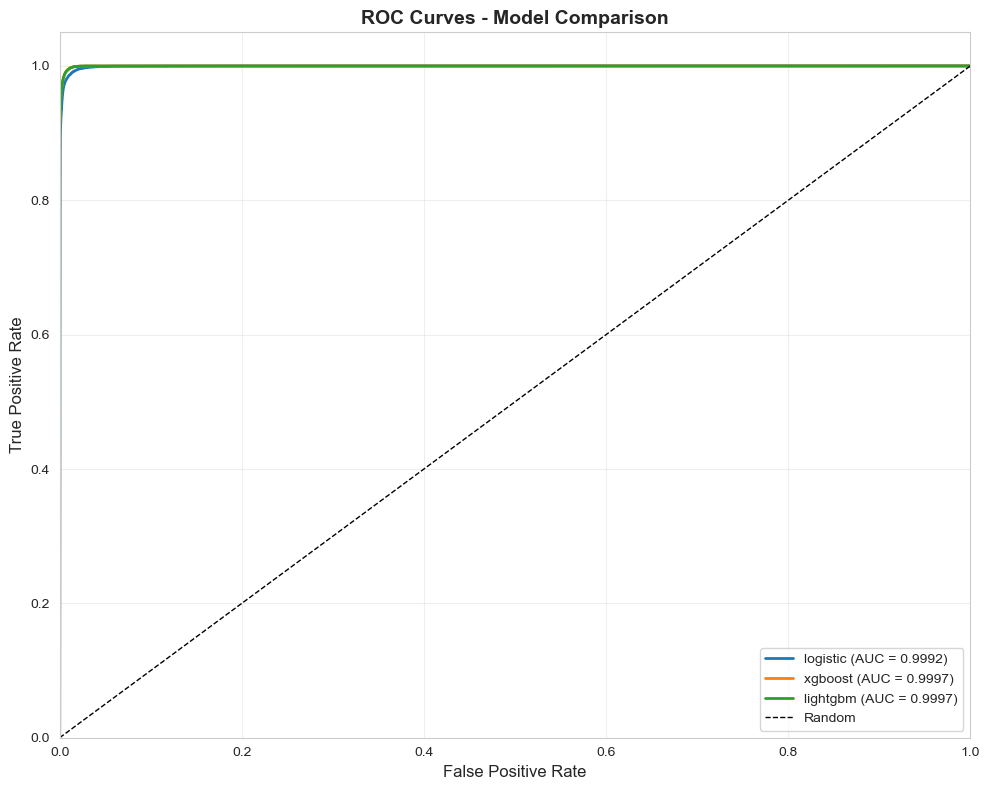

In [11]:
# Plot ROC curves for all models
if 'results' in locals() and results:
    from sklearn.metrics import roc_curve
    
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        roc_auc = result['metrics']['roc_auc']
        plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No results to plot. Train and evaluate models first.")


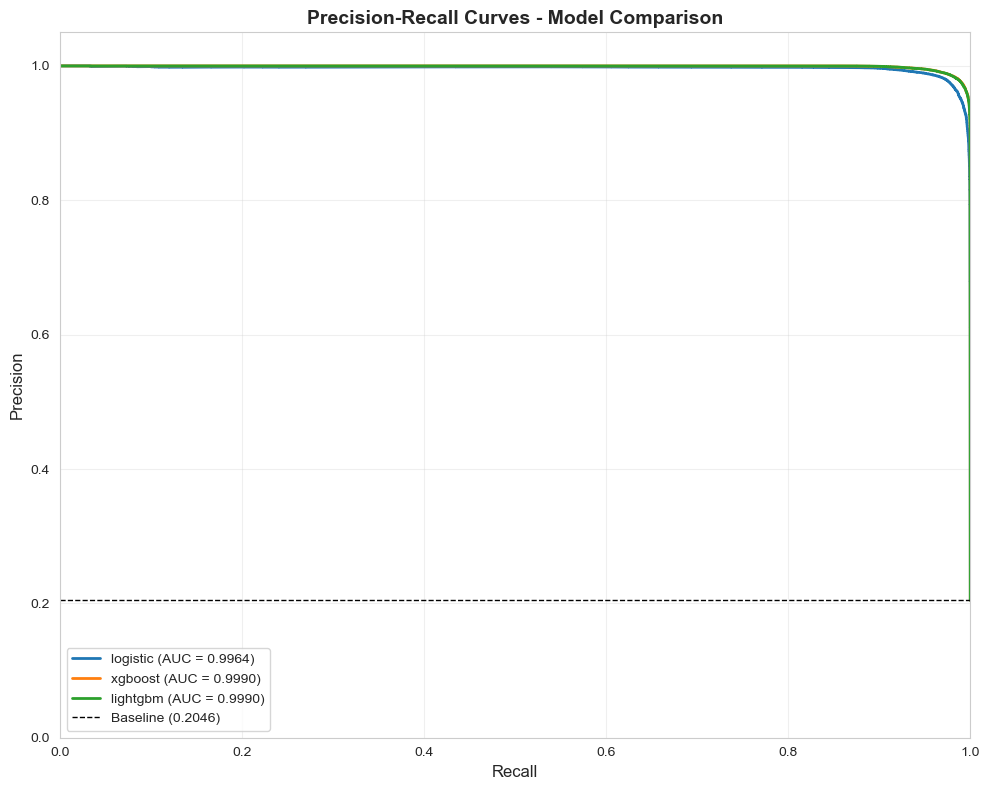

In [12]:
# Plot Precision-Recall curves
if 'results' in locals() and results:
    from sklearn.metrics import precision_recall_curve
    
    plt.figure(figsize=(10, 8))
    
    baseline = y_test.mean()
    
    for model_name, result in results.items():
        precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
        pr_auc = result['metrics']['pr_auc']
        plt.plot(recall, precision, linewidth=2, label=f'{model_name} (AUC = {pr_auc:.4f})')
    
    plt.axhline(y=baseline, color='k', linestyle='--', linewidth=1, label=f'Baseline ({baseline:.4f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Feature Importance Analysis



Feature Importance - XGBOOST


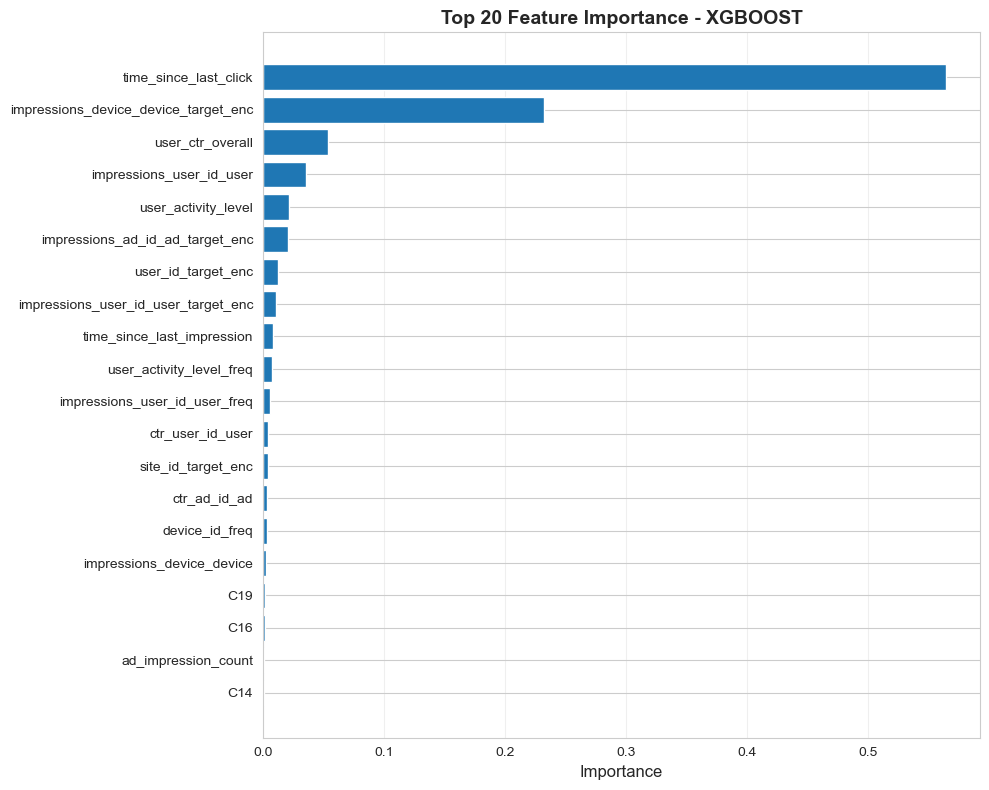


Top 10 features:
                                 feature  importance
3                  time_since_last_click    0.564073
1   impressions_device_device_target_enc    0.231937
2                       user_ctr_overall    0.053425
8               impressions_user_id_user    0.035664
7                    user_activity_level    0.021561
4        impressions_ad_id_ad_target_enc    0.020878
6                     user_id_target_enc    0.012244
5    impressions_user_id_user_target_enc    0.010667
30            time_since_last_impression    0.008132
12              user_activity_level_freq    0.007502

Feature Importance - LIGHTGBM


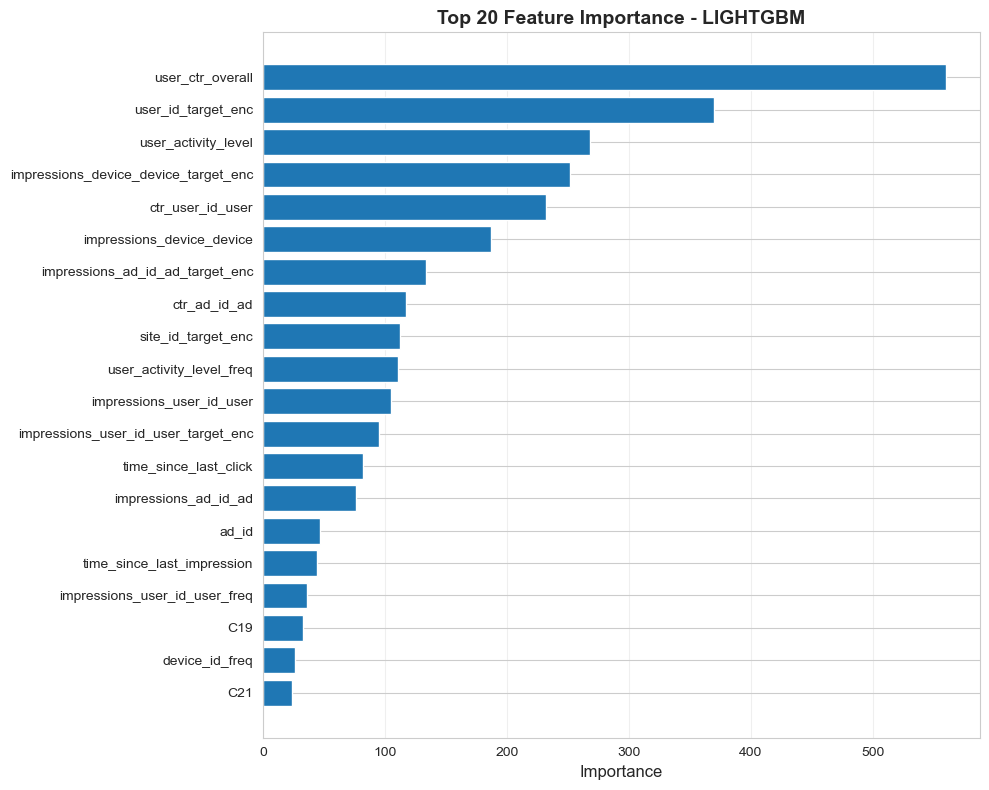


Top 10 features:
                                 feature  importance
2                       user_ctr_overall         560
6                     user_id_target_enc         370
7                    user_activity_level         268
1   impressions_device_device_target_enc         252
13                      ctr_user_id_user         232
20             impressions_device_device         187
4        impressions_ad_id_ad_target_enc         134
9                           ctr_ad_id_ad         117
11                    site_id_target_enc         112
12              user_activity_level_freq         111


In [13]:
# Plot feature importance for tree-based models
if models and feature_names:
    evaluator = ModelEvaluator()
    
    tree_models = ['xgboost', 'lightgbm']
    for model_name in tree_models:
        if model_name in models:
            print(f"\nFeature Importance - {model_name.upper()}")
            print("=" * 60)
            
            try:
                importance_df = evaluator.plot_feature_importance(
                    models[model_name],
                    feature_names,
                    top_n=20,
                    model_name=model_name.upper()
                )
                
                if importance_df is not None:
                    print(f"\nTop 10 features:")
                    print(importance_df.head(10))
            except Exception as e:
                print(f"⚠️  Could not plot feature importance: {e}")
else:
    print("⚠️  Cannot analyze feature importance: Missing models or feature names")


## Calibration Analysis

Check if predicted probabilities are well-calibrated.


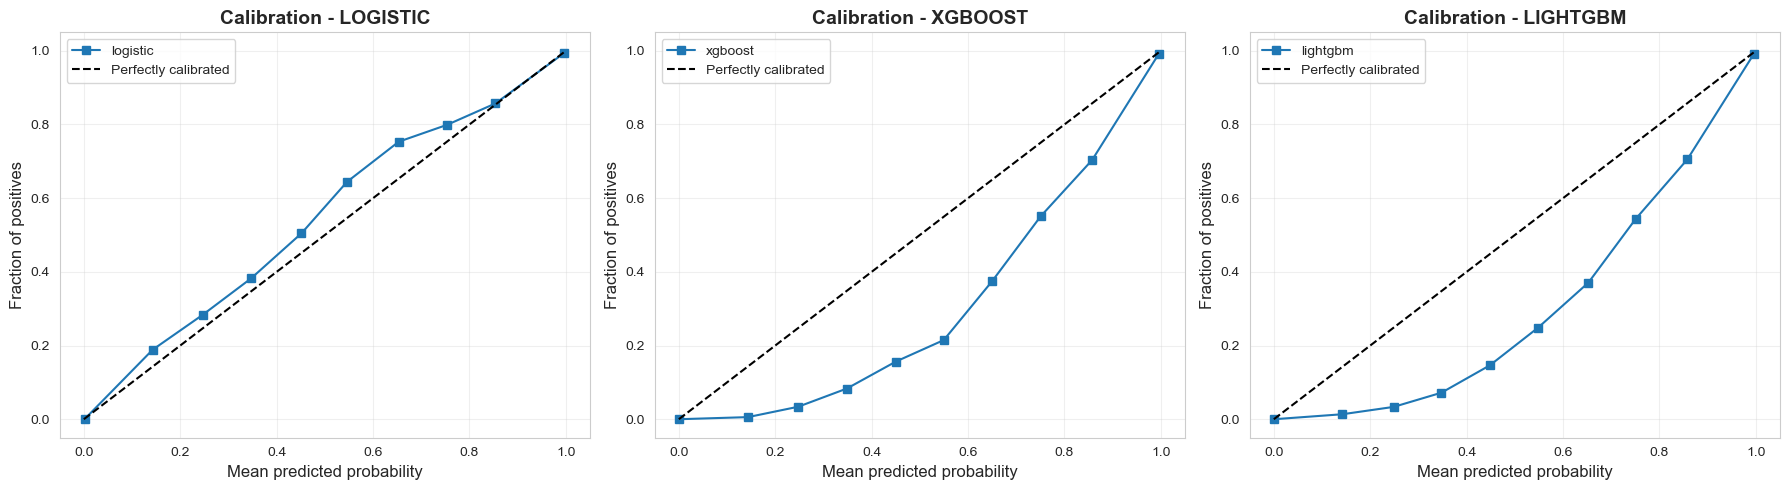

In [14]:
# Plot calibration curves
if 'results' in locals() and results:
    from sklearn.calibration import calibration_curve
    
    fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))
    if len(results) == 1:
        axes = [axes]
    
    for idx, (model_name, result) in enumerate(results.items()):
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, result['y_pred_proba'], n_bins=10
        )
        
        axes[idx].plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
        axes[idx].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
        axes[idx].set_ylabel('Fraction of positives', fontsize=12)
        axes[idx].set_xlabel('Mean predicted probability', fontsize=12)
        axes[idx].set_title(f'Calibration - {model_name.upper()}', fontsize=14, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No results to plot calibration curves")


## Prediction Examples

See how the model performs on individual predictions.


Using xgboost (ROC-AUC: 0.9997)

Prediction Examples:


,actual,predicted_prob,predicted_class,ad_id,impressions_device_device_target_enc,user_ctr_overall,time_since_last_click,impressions_ad_id_ad_target_enc
0,1,0.999756,1,17863,0.00000,1.0,0.0,0.177893
1,0,0.000057,0,21647,0.20455,0.0,31536000.0,0.421053
2,1,0.999821,1,16920,0.00000,1.0,0.0,0.238532
3,0,0.000082,0,12202,1.00000,0.0,31536000.0,0.194305
4,0,0.000055,0,21647,0.20455,0.0,31536000.0,1.000000
5,0,0.000057,0,20596,0.20455,0.0,31536000.0,0.400000
6,0,0.000050,0,21647,0.20455,0.0,31536000.0,0.187500
7,0,0.000055,0,15707,0.20455,0.0,31536000.0,0.083333
8,0,0.000119,0,21665,0.00000,0.0,31536000.0,0.377551
9,0,0.000108,0,21647,0.00000,0.0,31536000.0,0.300000


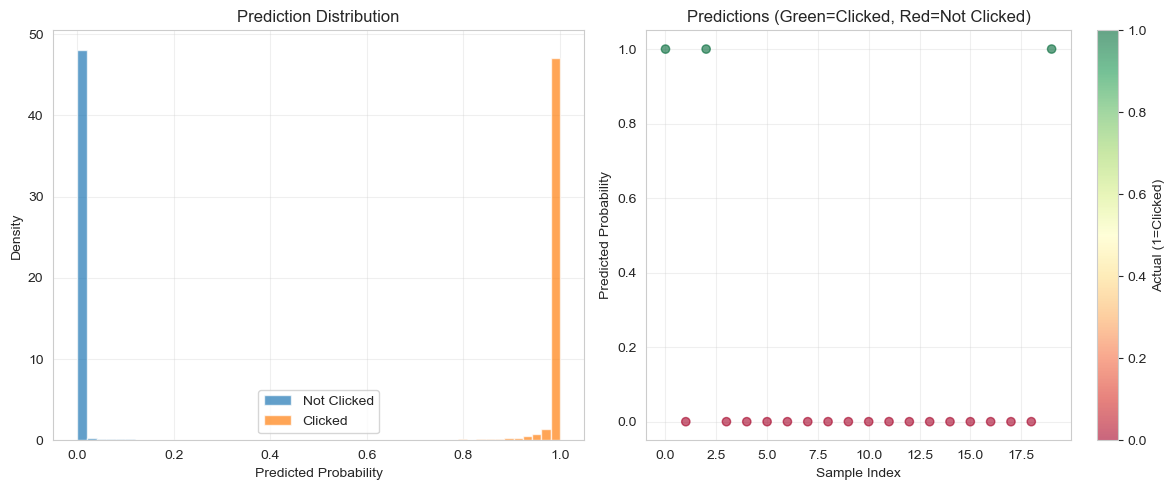

In [15]:
# Show prediction examples
if 'results' in locals() and results and 'X_test' in locals():
    # Use the best model (highest ROC-AUC)
    best_model_name = max(results.keys(), key=lambda x: results[x]['metrics']['roc_auc'])
    best_result = results[best_model_name]
    
    print(f"Using {best_model_name} (ROC-AUC: {results[best_model_name]['metrics']['roc_auc']:.4f})")
    print("\nPrediction Examples:")
    print("=" * 60)
    
    # Create results DataFrame
    examples_df = pd.DataFrame({
        'actual': y_test.values[:20],
        'predicted_prob': best_result['y_pred_proba'][:20],
        'predicted_class': best_result['y_pred_binary'][:20]
    })
    
    # Add some feature values for context
    if 'X_test' in locals():
        for col in X_test.columns[:5]:  # Show first 5 features
            examples_df[col] = X_test[col].values[:20]
    
    display(examples_df)
    
    # Show prediction distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(best_result['y_pred_proba'][y_test == 0], bins=50, alpha=0.7, label='Not Clicked', density=True)
    plt.hist(best_result['y_pred_proba'][y_test == 1], bins=50, alpha=0.7, label='Clicked', density=True)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Prediction Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(examples_df)), examples_df['predicted_prob'], 
               c=examples_df['actual'], cmap='RdYlGn', alpha=0.6)
    plt.xlabel('Sample Index')
    plt.ylabel('Predicted Probability')
    plt.title('Predictions (Green=Clicked, Red=Not Clicked)')
    plt.colorbar(label='Actual (1=Clicked)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Cannot show examples: Missing results or test data")
